In [82]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special
import jax
import duckdb

import imprint as ip
import confirm
import confirm.adagrid as ada
from confirm.adagrid.const import MAX_STEP
import confirm.cloud.clickhouse as ch

ip.setup_nb()

db = 'wd41_4d_v90'

ddb_path = Path(confirm.__file__).parent.parent.joinpath(f'{db}.db')
if ddb_path.exists():
    ddb = ada.DuckDBTiles(duckdb.connect(str(ddb_path), read_only=True))
    def query(q):
        return ddb.con.query(q).df()
else:
    ch_client = ch.connect(db, service='PROD')
    def query(q):
        return ch.query_df(ch_client, q)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-31 14:51:22,987 - imprint - DEBUG 
Enabling 64-bit floats in JAX.
2023-03-31 14:51:22,988 - confirm.cloud.clickhouse - INFO 
Clickhouse config: default@retpwkzwje.us-east-1.aws.clickhouse.cloud:8443/None
2023-03-31 14:51:23,185 - confirm.cloud.clickhouse - DEBUG 
Command took 0.018977880477905273 seconds
create database if not exists wd41_4d_v90
2023-03-31 14:51:23,185 - confirm.cloud.clickhouse - INFO 
Connected to job wd41_4d_v90


In [30]:
dim = len([c for c in query('select * from results limit 1').columns if c.startswith('theta')])
n_steps = query('select max(step_id) from results').iloc[0][0] + 1
dim, n_steps

2023-03-31 10:22:45,617 - confirm.cloud.clickhouse - DEBUG 
Query took 0.8692972660064697 seconds
select * from results limit 1
2023-03-31 10:22:47,971 - confirm.cloud.clickhouse - DEBUG 
Query took 2.3535518646240234 seconds
select max(step_id) from results


(4, 10)

## Broad table exploration

In [31]:
n_rows_df = pd.DataFrame(
    [(table, query(f'select count(*) from {table}').iloc[0][0]) for table in ch.all_tables],
    columns=['table', 'count']
).set_index('table')
n_rows_df

2023-03-31 10:22:59,486 - confirm.cloud.clickhouse - DEBUG 
Query took 0.08951306343078613 seconds
select count(*) from results
2023-03-31 10:22:59,518 - confirm.cloud.clickhouse - DEBUG 
Query took 0.03110504150390625 seconds
select count(*) from tiles
2023-03-31 10:22:59,552 - confirm.cloud.clickhouse - DEBUG 
Query took 0.0335848331451416 seconds
select count(*) from done
2023-03-31 10:22:59,573 - confirm.cloud.clickhouse - DEBUG 
Query took 0.020193099975585938 seconds
select count(*) from config
2023-03-31 10:22:59,603 - confirm.cloud.clickhouse - DEBUG 
Query took 0.029258012771606445 seconds
select count(*) from logs
2023-03-31 10:22:59,632 - confirm.cloud.clickhouse - DEBUG 
Query took 0.028653860092163086 seconds
select count(*) from reports
2023-03-31 10:22:59,663 - confirm.cloud.clickhouse - DEBUG 
Query took 0.030462980270385742 seconds
select count(*) from null_hypos


,count
table,
results,9508773
tiles,15573054
done,6535526
config,1
logs,5413
reports,1174
null_hypos,2


In [11]:
from confirm.adagrid.const import MAX_STEP
n_sims = query('select sum(K) from results').iloc[0][0]
n_retained_sims = query(f'select sum(K) from results where inactivation_step={MAX_STEP} and id not in (select id from done where active=false)').iloc[0][0]
n_sims / 1e12, n_retained_sims / 1e12

(0.077948174336, 0.074115825664)

In [12]:
n_active_tiles = query(
    f"select count(*) from results where inactivation_step={MAX_STEP}"
).iloc[0][0]
n_eligible_tiles = query(
    f"select count(*) from results where completion_step={MAX_STEP}"
).iloc[0][0]
n_active_tiles, n_eligible_tiles

(9047342, 9047342)

In [13]:
query(f'select K, count(*) as n_tiles from tiles where inactivation_step={MAX_STEP} group by K order by K')

,K,n_tiles
0,8192,9047342


In [14]:
volume_sql = (
    str(2 ** dim)
    + "*"
    + ("*".join([f"radii{d}" for d in range(dim)]))
)

In [15]:
smallest_tile = query(f'select * from results where inactivation_step={MAX_STEP} order by {volume_sql} limit 1')
smallest_tile

,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216444109899956816,7216444088425363824,-1.278125,-1.278125,-1.540625,-1.465625,0.009375,0.009375,0.009375,0.009375,True,False,8192,8,100,4294967295,0.018769,165,0.020362,False,0.023907,0.022191,0.018769,0.022446,0.02096,0.021841,0.022981,0.02189,0.024064,0.021409,0.023852,0.019823,0.022981,0.023344,0.021841,0.019471,0.021409,0.023852,0.021841,0.021179,0.020103,0.021959,0.019309,0.024023,0.023134,0.021409,0.023773,0.021764,0.019823,0.020301,0.024524,0.019823,0.021469,0.024872,0.022446,0.023134,0.021841,0.021409,0.023852,0.021469,0.023907,0.019823,0.021841,0.020103,0.022446,0.02309,0.023134,0.022983,0.023653,0.02288,0.023784,0.02309,0.023907,0.02323,4294967295


In [16]:
largest_tile = query(f'select * from results where inactivation_step={MAX_STEP} order by {volume_sql} desc limit 1')
largest_tile

,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216443418409613232,7216443409819852304,-1.2125,-1.2125,-1.8125,-1.3625,0.0375,0.0375,0.0375,0.0375,True,False,8192,3,76,4294967295,0.009171,85,0.010568,False,0.01327,0.01098,0.009171,0.010991,0.01026,0.010991,0.010991,0.011029,0.011754,0.010195,0.011548,0.008472,0.010991,0.011754,0.011155,0.009379,0.009379,0.011548,0.011054,0.010195,0.010122,0.010456,0.008853,0.01327,0.011029,0.009923,0.011054,0.011548,0.010195,0.009923,0.012576,0.011155,0.011548,0.011754,0.010928,0.012407,0.011054,0.011054,0.011054,0.009171,0.011548,0.009946,0.010991,0.010122,0.010928,0.010404,0.012188,0.012282,0.01026,0.011155,0.012169,0.011054,0.01327,0.010122,4294967295


In [17]:
n_possible_tiles = query('select count(*) from results where isNotNull(lams)').iloc[0][0]
n_possible_tiles

CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [18]:
lamss_tile = query(f'''
select * from results 
    where inactivation_step={MAX_STEP} 
        and isNotNull(lams) 
    order by lams 
    limit 1
''')
lamss_tile

CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [19]:
lamss = lamss_tile['lams'].iloc[0]

NameError: name 'lamss_tile' is not defined

2023-03-30 15:27:09,001 - confirm.cloud.clickhouse - DEBUG 
Query took 0.038573265075683594 seconds

select lams from results 
    where inactivation_step=4294967295 
        and lams <= nan



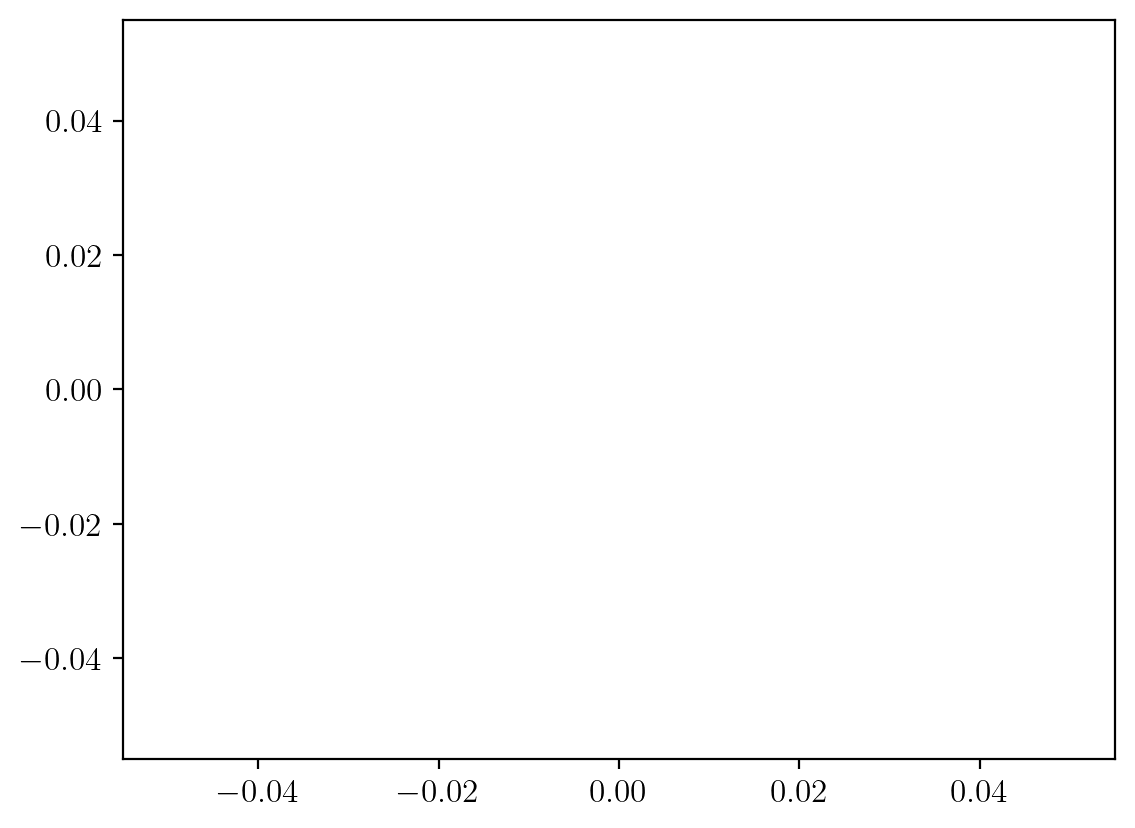

In [115]:
lams = query(f'''
select lams from results 
    where inactivation_step={MAX_STEP} 
        and lams <= {lamss}
''')
max_display = lamss * 2
plt.hist(lams['lams'], bins=np.linspace(lamss, max_display, 100))
plt.show()

## Ordering

In [21]:
worst5000_df = self.con.query('select * from results where inactivation_step>10000 order by lams limit 5000').df()

In [22]:
orderer_df = self.con.query(
    f"select orderer from results where inactivation_step>10000 and orderer <= {worst5000_df['orderer'].max()} order by orderer"
).df()


In [23]:
wait = np.searchsorted(orderer_df['orderer'], worst5000_df['orderer'])
wait

array([     0,      0,      0,      0,      0,      0,      0,      0,      0,     45, ..., 151702,
       151702, 151702,  63950,  63950,  63950,  63950,  63950,  63950,  95159])

In [15]:
cfg = self.get_config().iloc[0].to_dict()

In [47]:
import confirm.adagrid.calibrate as adacal
import confirm.models.wd41 as wd41
report = dict()
algo = adacal.AdaCalibrate(wd41.WD41(0, 600000, ignore_intersection=True), None, self, cfg, None)


In [48]:
tiles_df = self.next(10, 11, 50000, 'orderer')
twb_worst_tile = self.worst_tile(10, "twb_mean_lams")
# np.sum(tiles_df['twb_min_lams'] > twb_worst_tile['twb_mean_lams'].iloc[0])

In [51]:
self = algo
twb_worst_tile = self.db.worst_tile(10, "twb_mean_lams")
for col in twb_worst_tile.columns:
    if col.startswith("radii"):
        twb_worst_tile[col] = 1e-6
twb_worst_tile["K"] = self.max_K
twb_worst_tile_lams = self.driver.bootstrap_calibrate(
    twb_worst_tile,
    self.cfg["alpha"],
    calibration_min_idx=self.cfg["calibration_min_idx"],
    tile_batch_size=1,
)
twb_worst_tile_mean_lams = twb_worst_tile_lams["twb_mean_lams"].iloc[0]
deepen_likely_to_work = tiles_df["twb_min_lams"] > twb_worst_tile_mean_lams

In [53]:
np.sum(deepen_likely_to_work)

0

## Looking at the reports

In [83]:
import json
report_df = pd.DataFrame([json.loads(v) for v in query('select * from reports')['json'].values])
working_reports = report_df[report_df['status'] == 'WORKING'].dropna(axis=1, how='all')
new_step_reports = report_df[report_df['status'] == 'NEW_STEP'].dropna(axis=1, how='all')
new_step_reports.set_index('step_id', inplace=True)

2023-03-31 14:51:27,667 - confirm.cloud.clickhouse - DEBUG 
Query took 0.5139117240905762 seconds
select * from reports


In [1]:
import coiled

cluster = await coiled.Cluster(
    name="confirm-coiled",
    software="confirm-coiled",
    n_workers=1,
    worker_vm_types=["g4dn.xlarge"],
    worker_gpu=1,
    compute_purchase_option="spot_with_fallback",
    shutdown_on_close=False,
    scheduler_options={"idle_timeout": "60 minutes"},
    allow_ssh=True,
    wait_for_workers=1,
    worker_options={"nthreads": 2},
    asynchronous=True
)

Output()

In [4]:
await cluster.scale(16)

In [128]:
client = await cluster.get_client()

In [157]:
cluster

KeyboardInterrupt: 

In [148]:
def large_return():
    import numpy as np
    import time
    time.sleep(2)
    return np.random.uniform(size=(4000, 4000))

In [149]:
%%time
A = large_return()

CPU times: user 65.9 ms, sys: 14.6 ms, total: 80.5 ms
Wall time: 2.08 s


In [156]:
import time
import asyncio
start = time.time()
R = asyncio.create_task(client.submit(large_return).result())
await asyncio.sleep(4)
RR = await R
print(time.time() - start)

5.791484832763672


2023-03-31 16:35:07,742 - distributed.client - ERROR - 'cancelled-key'
Traceback (most recent call last):
  File "/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/distributed/client.py", line 1562, in _handle_report
    handler = self._stream_handlers[op]
KeyError: 'cancelled-key'


2023-03-31 16:35:07,742 - distributed.client - ERROR 
'cancelled-key'
Traceback (most recent call last):
  File "/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/distributed/client.py", line 1562, in _handle_report
    handler = self._stream_handlers[op]
KeyError: 'cancelled-key'


In [98]:
fut = await client.scatter([1,2,3], broadcast=True)

In [127]:
import time
import asyncio
start = time.time()
fut2 = client.submit(lambda x: x + [2], fut)
async def wait_for_dask_fut(f):
    return await f
await asyncio.create_task(wait_for_dask_fut(fut2))
print(time.time() - start)

0.05527496337890625


In [107]:
client.get(fut2)

TypeError: Client.get() missing 1 required positional argument: 'keys'

In [93]:
print(cluster)

ClusterBeta(confirm-coiled, '<Not Connected>', workers=0, threads=0, memory=0 B)


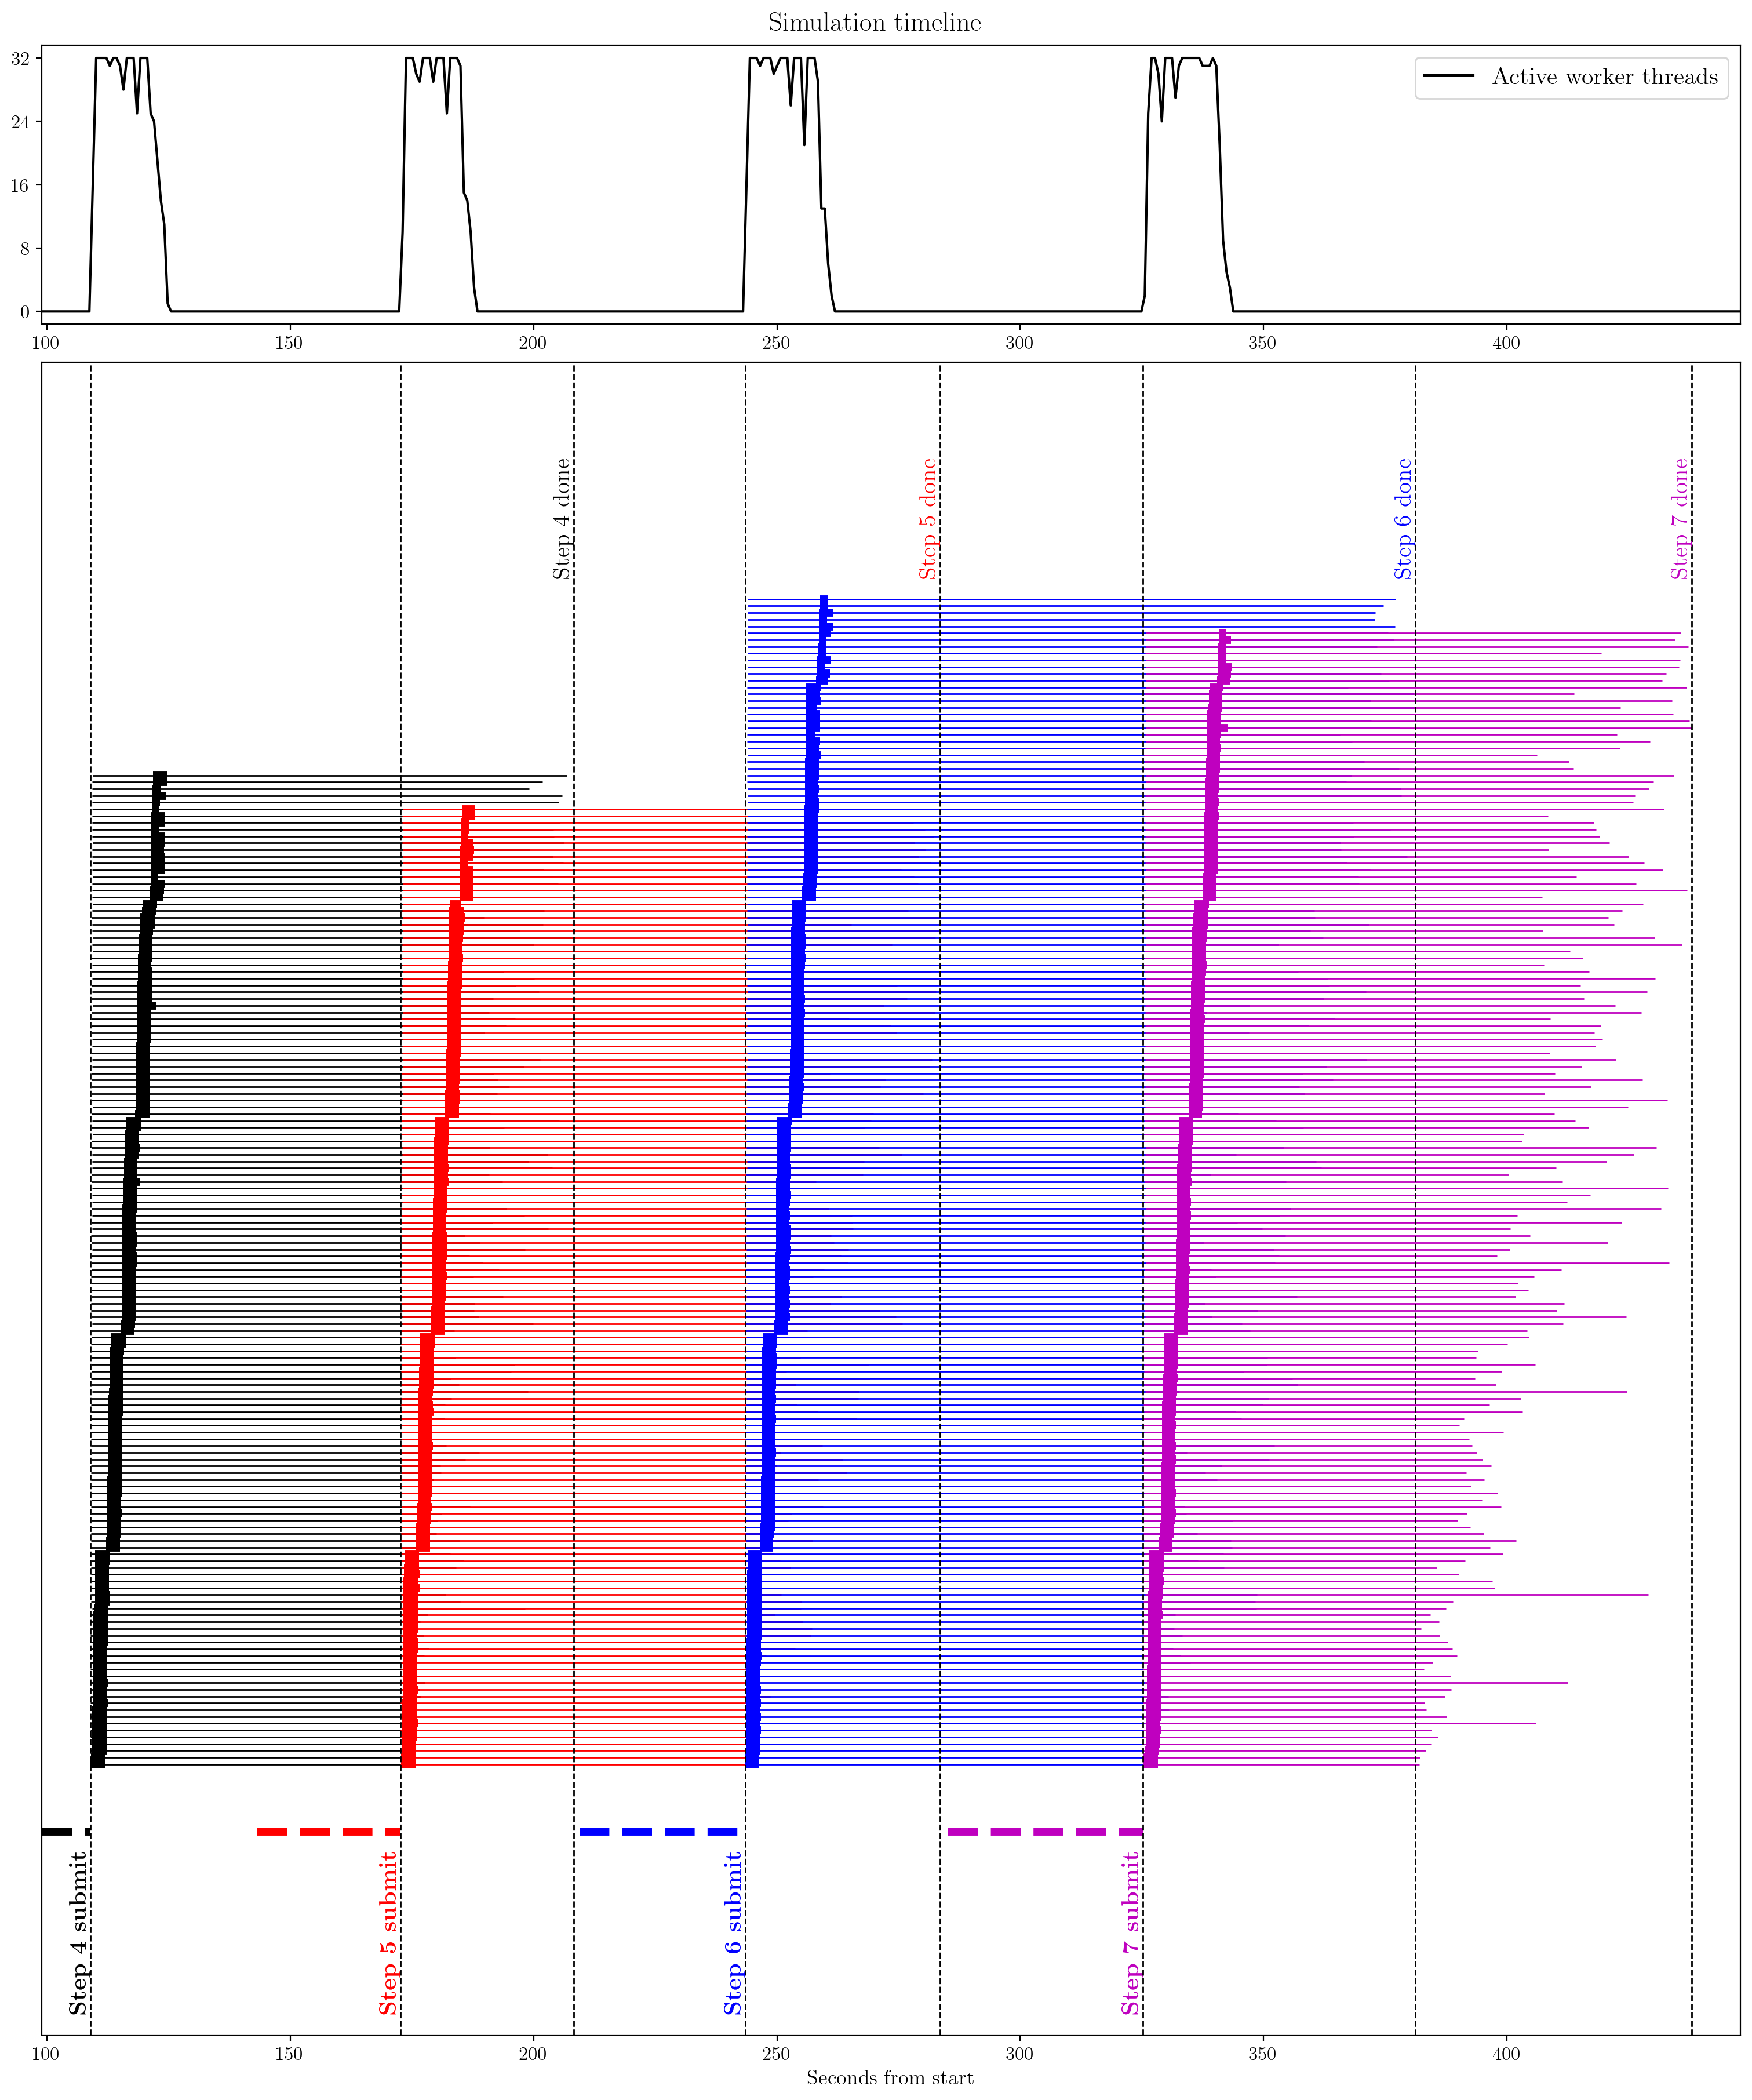

In [84]:
from matplotlib.gridspec import GridSpec

min_step = 4
max_step = 10
color_list = ["k", "r", "b", "m"]
offset = report_df["start_time"].min()

step_id = working_reports["step_id"]
include = (step_id >= min_step) & (step_id <= max_step)
df = working_reports[include][
    ["sim_start_time", "sim_done_time", "start_time", "done_time", "step_id"]
].copy()
df.sort_values(by=["sim_start_time"], inplace=True)
df["adjusted_start_time"] = df["start_time"] - offset
df["adjusted_done_time"] = df["done_time"] - offset
df["adjusted_sim_start_time"] = df["sim_start_time"] - offset
df["adjusted_sim_done_time"] = df["sim_done_time"] - offset
min_time = df["adjusted_start_time"].min() - 10
max_time = df["adjusted_done_time"].max() + 10

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["packet_linelengths"] = df["done_time"] - df["start_time"]
df["packet_lineoffsets"] = df["adjusted_start_time"] + df["packet_linelengths"] * 0.5
df["packet_linewidths"] = 1

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["linelengths"] = df["sim_done_time"] - df["sim_start_time"]
df["lineoffsets"] = (
    df["sim_start_time"] - report_df["start_time"].min() + df["linelengths"] * 0.5
)
df["colors"] = np.array(color_list)[df["step_id"] % len(color_list)]
df["linewidths"] = 5
fig = plt.figure(figsize=(15, 18), constrained_layout=True)
plt.suptitle("Simulation timeline")
gs = GridSpec(7, 1, figure=fig)
plt.subplot(gs[0, 0])
ts = np.linspace(min_time, max_time, 500)
ongoing = []
for t in ts:
    ongoing.append(
        ((df["adjusted_sim_start_time"] < t) & (df["adjusted_sim_done_time"] > t)).sum()
    )
plt.plot(ts, ongoing, "k-", label="Active worker threads")
plt.legend()
plt.xlim([min_time, max_time])
plt.yticks(np.arange(0, 33, 8))

plt.subplot(gs[1:, 0])
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="packet_lineoffsets",
    linelengths="packet_linelengths",
    linewidths="packet_linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="lineoffsets",
    linelengths="linelengths",
    linewidths="linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)

new_step_reports["adjusted_step_start_time"] = (
    new_step_reports["time"] - new_step_reports["runtime_total"] - offset
)
new_step_reports["adjusted_step_done_time"] = new_step_reports["time"] - offset
for step_id in range(min_step, max_step + 1):
    try:
        rpt = new_step_reports.loc[step_id]
    except KeyError:
        continue
    plt.plot(
        [
            rpt["adjusted_step_start_time"],
            rpt["adjusted_step_done_time"],
        ],
        [-1, -1],
        color_list[step_id % len(color_list)],
        linestyle='--',
        linewidth=5,
    )

for step_id, step_df in df.groupby("step_id"):
    plt.axvline(
        step_df["adjusted_start_time"].min(),
        color="k",
        linestyle="--",
        linewidth=1,
        zorder=100,
    )
    plt.axvline(
        step_df["adjusted_done_time"].max(), color="k", linestyle="--", linewidth=1
    )
for step_id, step_df in df.groupby("step_id"):
    plt.text(
        step_df["adjusted_start_time"].min(),
        -3.7,
        "$\\textbf{Step " + str(step_id) + " submit}$",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
        bbox=dict(facecolor="w", edgecolor="w", boxstyle="round"),
    )
    plt.text(
        step_df["adjusted_done_time"].max(),
        df["positions"].max() + 0.3,
        f"Step {step_id} done",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
    )
plt.xlabel("Seconds from start")
plt.xlim([min_time, max_time])
plt.ylim([-4, df["positions"].max() + 3.5])
plt.gca().get_yaxis().set_visible(False)

plt.show()


In [81]:
sim_runtime = working_reports['runtime_simulating'].sum()
total_runtime = report_df['done_time'].max() - report_df['start_time'].min()
parallelism = sim_runtime / total_runtime
parallelism, sim_runtime / 3600, total_runtime / 3600

(1.9045489957208175, 0.7726859554979536, 0.4057054752773709)

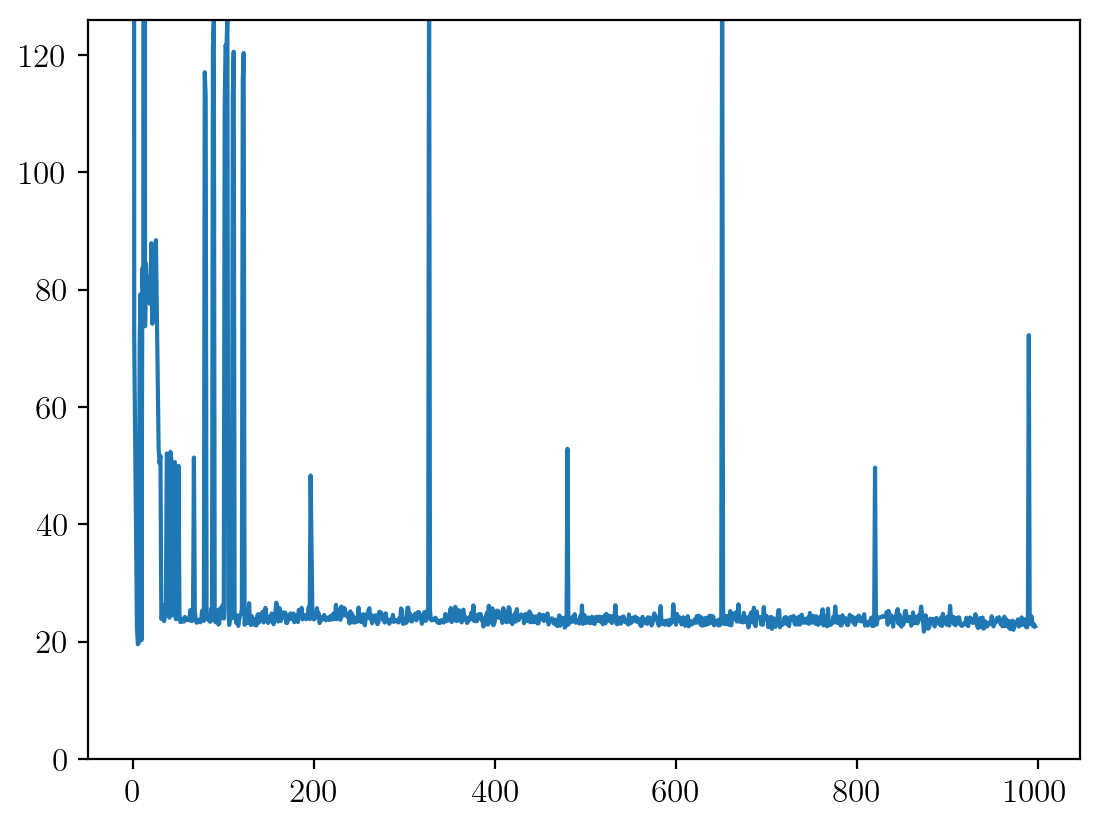

In [26]:
plt.plot(working_reports['runtime_per_sim_ns'])
plt.ylim([0, np.percentile(working_reports['runtime_per_sim_ns'], 99.5)])
plt.show()

In [34]:
working_reports

,step_id,packet_id,n_tiles,n_total_sims,runtime_simulating,runtime_per_sim_ns,time,status,runtime_total
0,0,1.0,872.0,7143424.0,4.368992,611.610355,1.680043e+09,WORKING,18.268311
1,0,0.0,8192.0,67108864.0,4.800759,71.536878,1.680043e+09,WORKING,19.177590
4,1,0.0,8192.0,67108864.0,1.509101,22.487356,1.680043e+09,WORKING,2.113492
5,1,1.0,8192.0,67108864.0,1.312450,19.557028,1.680043e+09,WORKING,3.374148
6,1,7.0,8192.0,67108864.0,1.326726,19.769764,1.680043e+09,WORKING,4.753341
...,...,...,...,...,...,...,...,...,...
993,8,158.0,8192.0,67108864.0,1.632083,24.319931,1.680044e+09,WORKING,129.634347
994,8,164.0,8192.0,67108864.0,1.561535,23.268679,1.680044e+09,WORKING,130.253397
995,8,166.0,8192.0,67108864.0,1.518232,22.623414,1.680044e+09,WORKING,130.397383
996,8,163.0,8192.0,67108864.0,1.537456,22.909884,1.680044e+09,WORKING,130.543943


In [33]:
working_reports['runtime_simulating'].sum()

1753.1391277313232

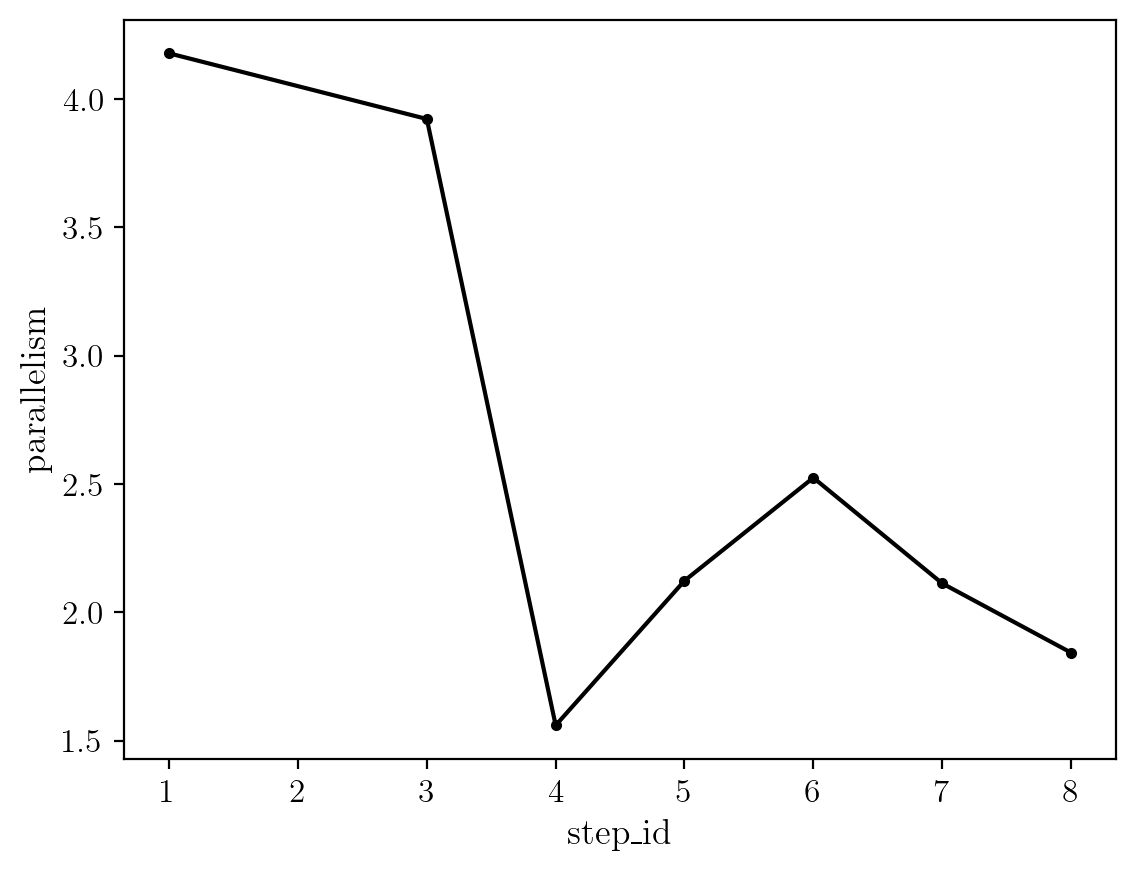

In [27]:
max_working_time = working_reports.groupby('step_id')['time'].max()
total_sim_time = working_reports.groupby('step_id')['runtime_simulating'].sum()
ex_df = new_step_reports[['step_id', 'runtime_total', 'time']].set_index('step_id')
ex_df['max_working_time'] = max_working_time
ex_df['total_sim_time'] = total_sim_time
step_parallelism = ex_df['total_sim_time'] / ((ex_df['max_working_time'] - ex_df['time']) + ex_df['runtime_total'])
plt.plot(step_parallelism, 'k-o', markersize=3)
plt.xlabel('step_id')
plt.ylabel('parallelism')
plt.show()

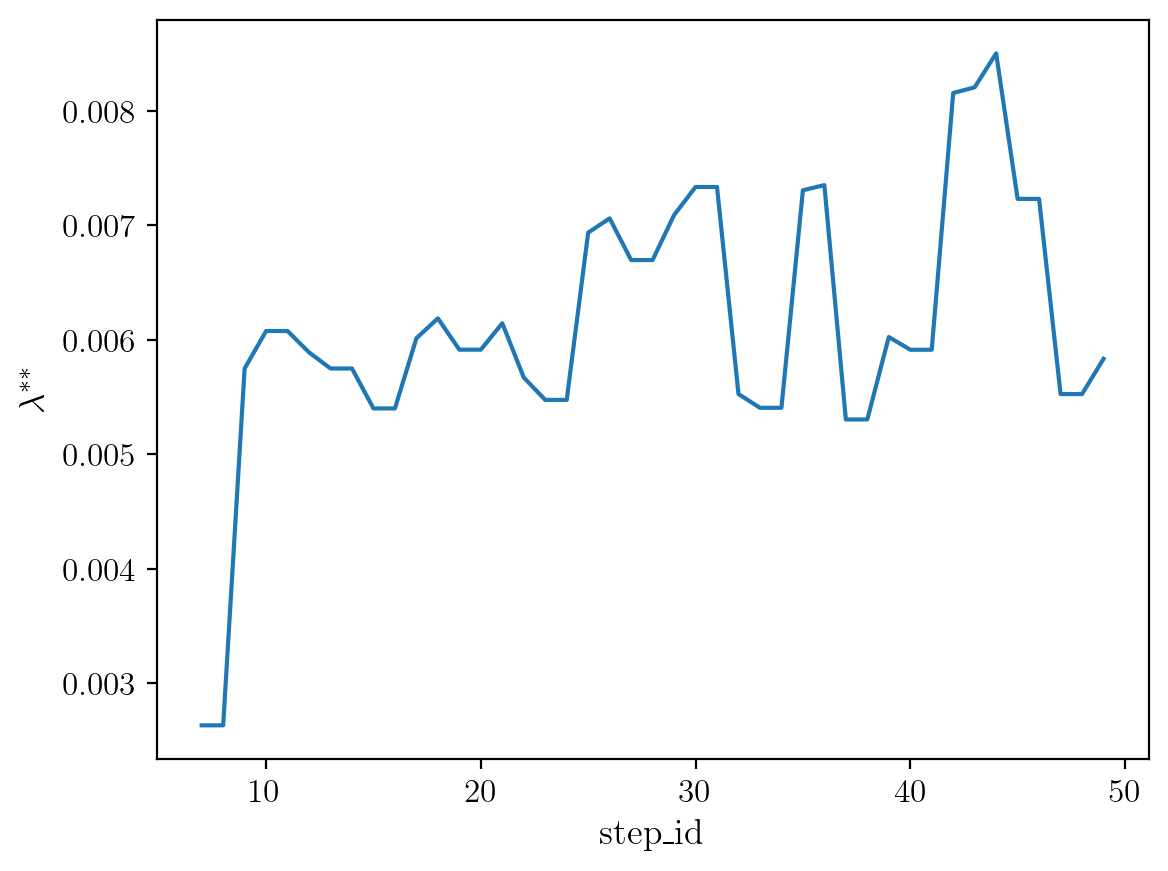

In [16]:
plt.plot(new_step_reports[['step_id', 'lamss']].set_index('step_id'))
plt.xlabel('step_id')
plt.ylabel('$\lambda^{**}$')
plt.show()

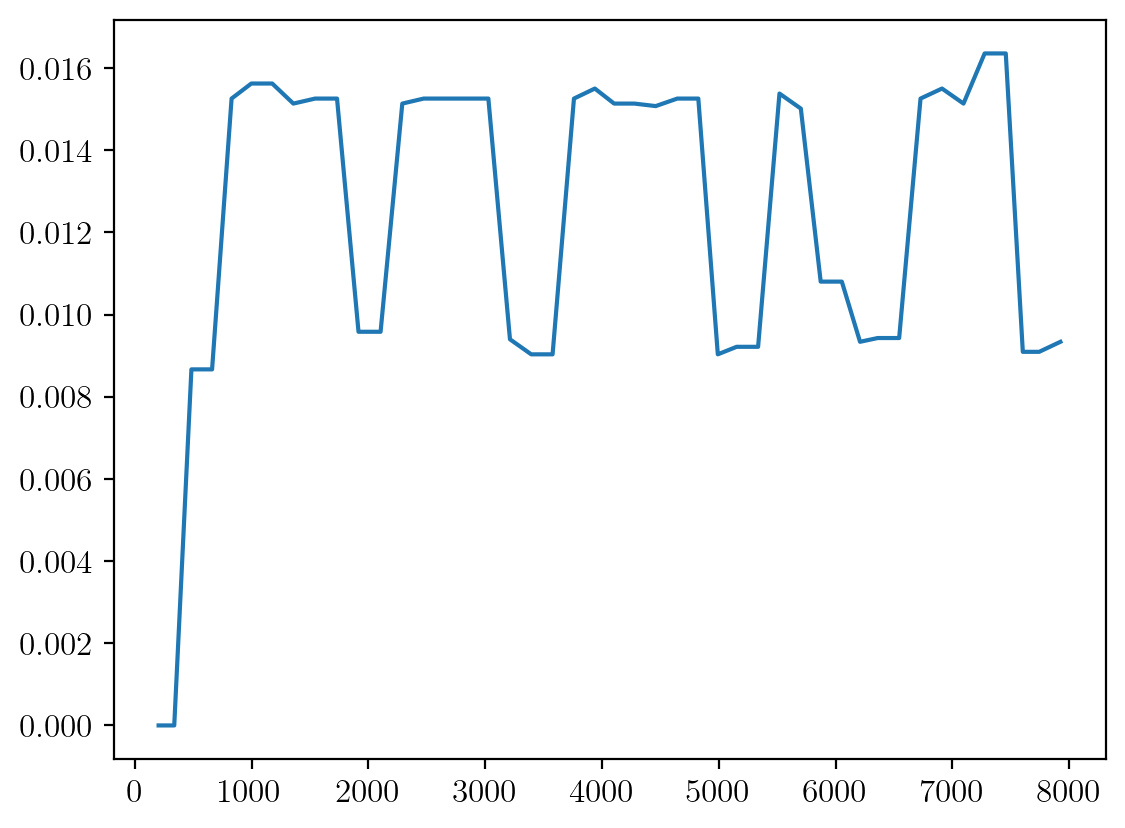

In [17]:
plt.plot(new_step_reports['tie_{k}(lamss)'])
plt.show()

In [19]:
import numpy as np
xs = np.linspace(-2, 1, 10)
ys = np.linspace(-2, 1, 10)
counts = np.empty((len(xs), len(ys)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        NN = self.con.query(f'''
            select count(*) 
                from results
                where 
                    inactivation_step={MAX_STEP}
                    and abs(theta0 - {x}) < 0.167
                    and abs(theta2 - {y}) < 0.167
        ''').fetchone()[0]
        counts[i, j] = NN

In [20]:
counts.sum() / 1e6

61.254279

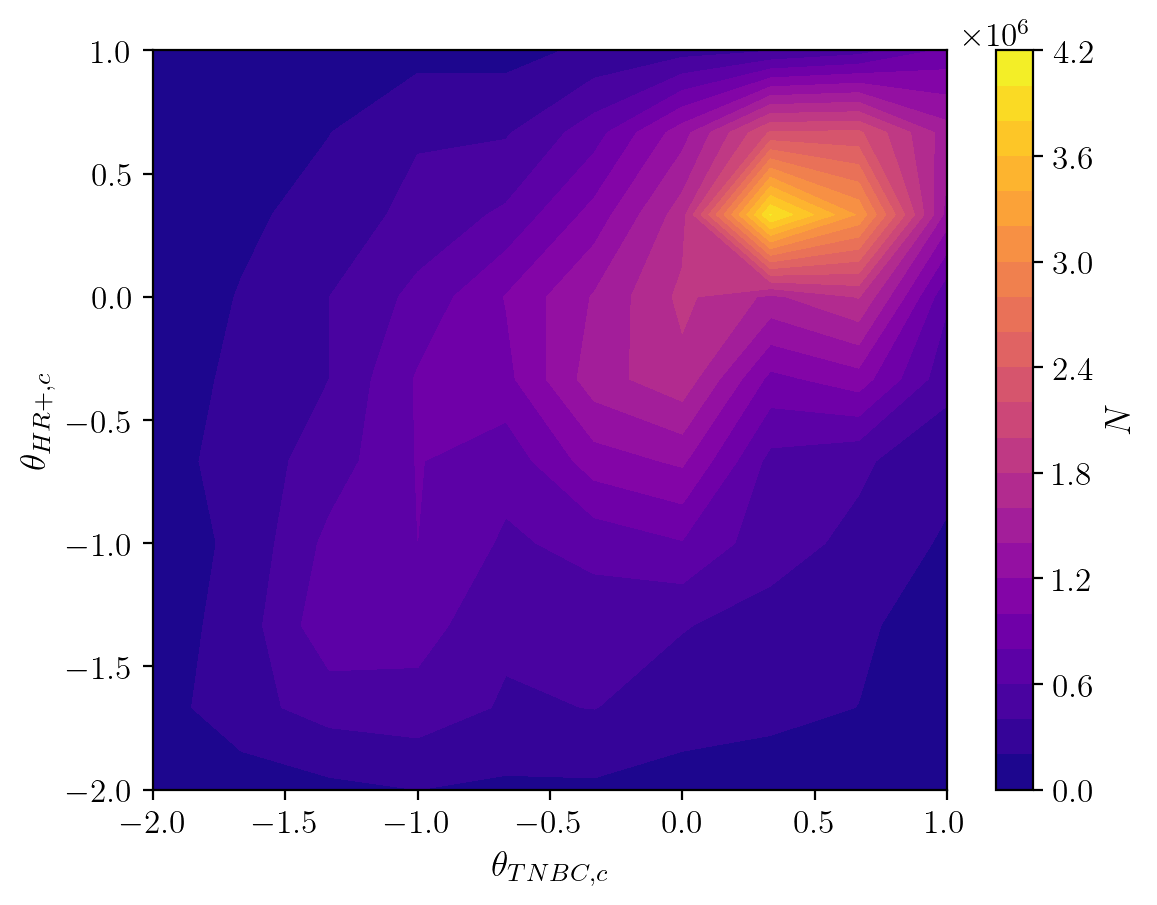

In [21]:
XX, YY = np.meshgrid(xs, ys, indexing='ij')
# plt.scatter(XX.ravel(), YY.ravel(), c=counts.ravel())
plt.contourf(XX, YY, counts, levels=20)
plt.xlabel('$\\theta_{TNBC, c}$')
plt.ylabel('$\\theta_{HR+, c}$')
cbar = plt.colorbar()
cbar.set_label('$N$')
plt.show()

In [22]:
plot_df = self.con.query('''
    select theta0, theta1, theta2, theta3, 
            radii0, radii1, radii2, radii3, 
            alpha0, K, lams, twb_mean_lams, twb_min_lams 
        from results
        where 
            abs(theta0 + 1) < 0.05
            and abs(theta2 + 1) < 0.05
''').df()

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['K'], s=5)
plt.colorbar()
plt.subplot(2, 2, 2)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['alpha0'], s=5)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['lams'], s=5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['twb_min_lams'], s=5)
plt.colorbar()
plt.show()